In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import math
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

import statsmodels.api as sm


#Code to always set working directory one level up so we can access /data easily
import os
if "NOTEBOOK_DIR" not in globals():
    NOTEBOOK_DIR = os.getcwd()
    print('Notebook Directory Set:', os.getcwd())

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Current working directory: /shared_folder/eas_508_project


In [114]:
#Create Remove Plays func for clean_data func
def remove_plays(dataframe):
    df = dataframe.copy()

    formation = df['offense_formation'].notna()
    personnel = df['offense_personnel'].notna()
    no_play = df['play_type'] != 'no_play'
    kneel = df['qb_kneel'] == 0
    spike = df['qb_spike'] == 0

    df = df[formation & personnel & no_play & kneel & spike].drop(columns=['qb_kneel','qb_spike'])

    df = df[df['down'].notna()]

    return df

In [115]:
pbp_path = 'data/raw/pbp_data/'

pbp_name = 'pbp_2016.csv'

fb_df = pd.read_csv(pbp_path + pbp_name)
shape = fb_df.shape
columns = fb_df.columns

print('✔✔✔ File Loaded\n')
print(f'Shape: {shape}\n')
print(f'Column Names: {list(columns)}\n')

fb_df.head()

/tmp/ipykernel_29045/3081738536.py:5: DtypeWarning: Columns (196,197,199,200,206,207,210,211,214,215,220,221,222,223,226,227,235,236,237,265,266,270,271,272,277,279,280,300,301) have mixed types. Specify dtype option on import or set low_memory=False.
  fb_df = pd.read_csv(pbp_path + pbp_name)


✔✔✔ File Loaded

Shape: (47651, 389)

Column Names: ['nflverse_game_id', 'play_id', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'players_on_play', 'offense_players', 'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type', 'defense_coverage_type', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_poin

,nflverse_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,2016_01_BUF_BAL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016_01_BUF_BAL,36,BUF,NaN,NaN,NaN,NaN,NaN,40078;40151;37977;36060;40494;40053;40253;4011...,00-0030041;00-0030073;00-0029799;00-0030433;00...,...,0,1,-0.955114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016_01_BUF_BAL,58,BAL,I_FORM,"2 RB, 1 TE, 2 WR",8.0,"4 DL, 3 LB, 4 DB",NaN,38540;41302;40078;35553;38582;43295;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,1,1,0.336466,NaN,NaN,NaN,NaN,NaN,0.460759,-46.075901
3,2016_01_BUF_BAL,85,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",3.0,41302;40078;38540;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,0.644540,1.567466,9.753489,8.0,0.63767,0.530295,0.426425,57.357508
4,2016_01_BUF_BAL,109,BAL,SHOTGUN,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",NaN,40078;38540;41302;35553;43295;38582;40053;4336...,00-0029892;00-0027714;00-0032965;00-0029893;00...,...,0,1,-0.546209,NaN,NaN,NaN,NaN,NaN,0.456597,-45.659652


In [116]:
df = remove_plays(fb_df)

In [117]:
#Convert Offense Personnel to Dictionary Storage for easy recall
def fix_personnel(dataframe):
    df = dataframe.copy()

    df['personnel_dict'] = df['offense_personnel'].apply(lambda x: {pos: int(count) for count, pos in (p.strip().split(' ') for p in x.split(','))})

    df['QB'] = 1
    df['OL'] = 5

    personnel_titles = ['RB','TE','WR','OTHER']

    for pos in personnel_titles:
        df[f'{pos}'] = 0

    def update_personnel_counts(row):
        for k,v in row['personnel_dict'].items():
            if k in personnel_titles:
                row[k] += v
            else:
                if k == 'QB':
                    row[k] = v
                elif k == 'OL':
                    row[k] = v
                else:
                    row['OTHER'] += v
        return row

    df = df.apply(update_personnel_counts, axis=1)

    df = df.drop(columns = ['personnel_dict','offense_personnel'])

    df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)

    df['bigs'] = df['OL']+df['TE']-5
    df['personnel_num'] = df.apply(lambda x: f'{x['bigs']}{x['RB']}', axis=1)

    return df

In [118]:
df = fix_personnel(df)

/tmp/ipykernel_29045/1925525035.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['extra_lineman_flag'] = np.where(df['OL'] > 5, 1, 0)
/tmp/ipykernel_29045/1925525035.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bigs'] = df['OL']+df['TE']-5
/tmp/ipykernel_29045/1925525035.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [119]:
def win_trim(dataframe, win_perc=0):
    df = dataframe.copy()

    return df[(win_perc < df['wp']) & (df['wp'] < (1-win_perc))]

In [120]:
def model_prep(dataframe, win_perc, features, to_predict=['success']):
    df = dataframe.copy()
    cols_to_keep = features+to_predict

    df = win_trim(df)

    return df[cols_to_keep]

### Need to make more features. Features to make:
- Previous Success
- ydstosuccess
- one hot encode down
- maybe make down inverted instead
- home/away
- run/pass based on predictive factors
- defensive personnel number
- make distance to goal, opposite of absolute yard line
- defenders in box, make density-> n/11
- big/small feature, compare OL+TE vs DL, RB+TE vs LB, WR vs DB
- Train seperate model to predict +/- EPA gain
- Maybe categorize yards to success rounded in bins from 0-5, 5-10, 10-20 etc. -> 0,4 might be best bin size
- Run/Pass by formation, personnel
- EPA, Success Rate averaged by formation
- Do I need to smooth

In [121]:
def yds_to_success(dataframe):
    df = dataframe.copy()

    df['ydstosuccess'] = np.where(df['down']==1, df['ydstogo']*.5, np.where(df['down']==2, df['ydstogo']*.7, df['ydstogo']))

    return df

In [122]:
df = yds_to_success(df)

df['ydstosuccess_rounded'] = df['ydstosuccess'].apply(lambda x: math.ceil(x))

In [123]:
df['previous_success'] = df.groupby(['nflverse_game_id','fixed_drive'])['success'].shift(1)

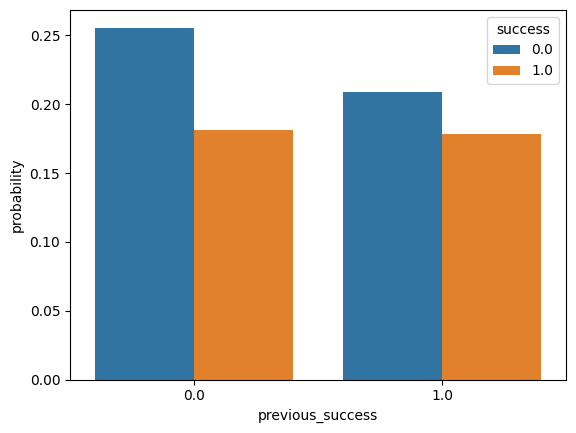

In [124]:
sns.countplot(data=df, x='previous_success', hue='success', stat='probability')
plt.show()

In [125]:
df['previous_success'].fillna(1)

2        1.0
3        1.0
4        1.0
5        0.0
6        1.0
        ... 
47644    1.0
47645    0.0
47646    1.0
47648    1.0
47649    0.0
Name: previous_success, Length: 33354, dtype: float64

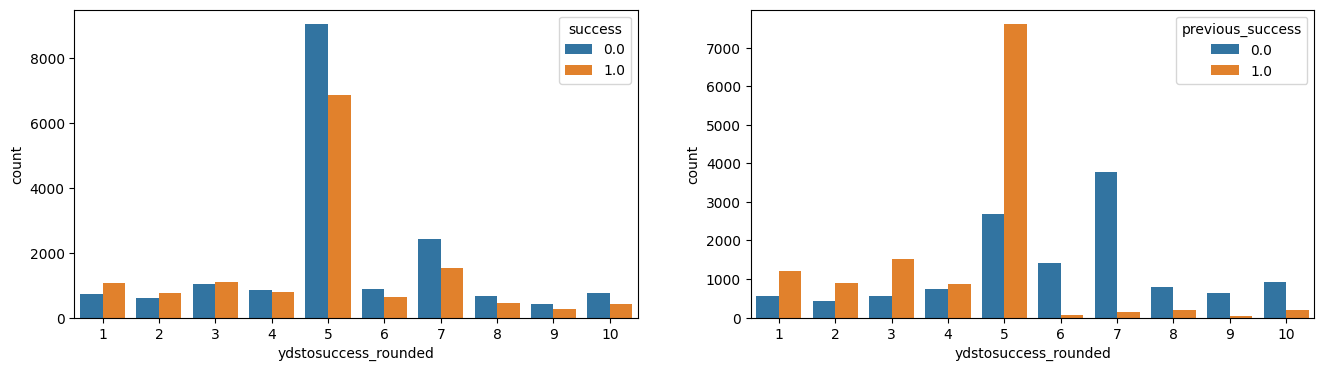

In [126]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='success', ax=axes[0])
sns.countplot(data=df[df['ydstosuccess_rounded']<11], x ='ydstosuccess_rounded', hue='previous_success', ax=axes[1])

plt.show()

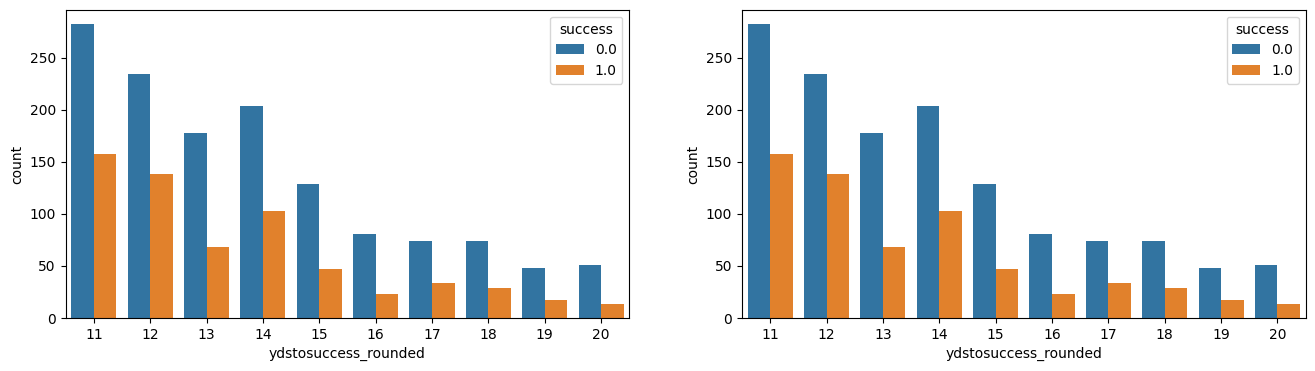

In [127]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df[(df['ydstosuccess_rounded']<21) & (df['ydstosuccess_rounded']>10)], x ='ydstosuccess_rounded', hue='success', ax=axes[0])
sns.countplot(data=df[(df['ydstosuccess_rounded']<21) & (df['ydstosuccess_rounded']>10)], x ='ydstosuccess_rounded', hue='success', ax=axes[1])

plt.show()

In [128]:
yard_bins = [0, 4, 8, 12, 16, np.inf]
yard_labels = ['0to4','4to8','8to12','12to16','16to']

df['yard_group'] = pd.cut(df['ydstosuccess_rounded'], bins=yard_bins, labels=yard_labels, right=True)

df['yard_group'].value_counts()

yard_group
4to8      22417
0to4       6901
8to12      2697
12to16      828
16to        511
Name: count, dtype: int64

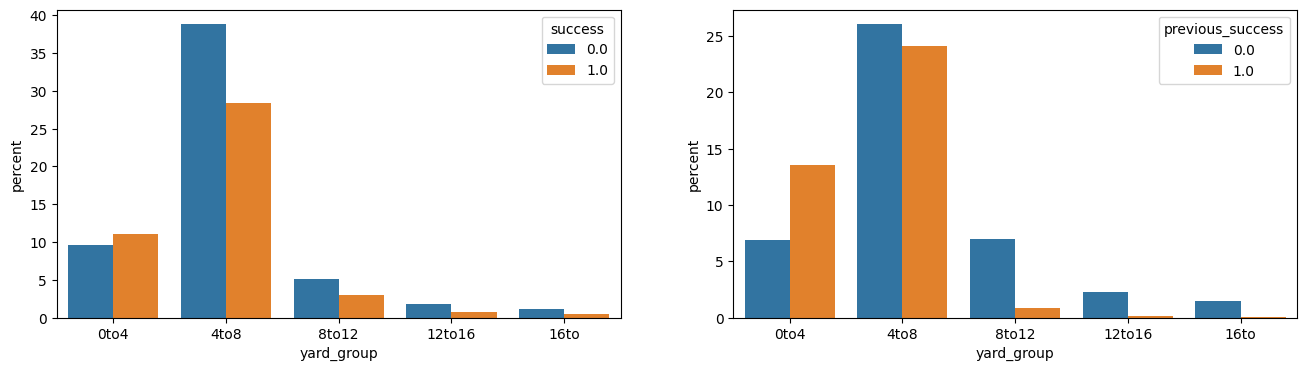

In [129]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.countplot(data=df, x ='yard_group', hue='success', stat='percent', ax=axes[0])
sns.countplot(data=df, x ='yard_group', hue='previous_success', stat='percent', ax=axes[1])

plt.show()

In [130]:
df['offense_formation']

2            I_FORM
3           SHOTGUN
4           SHOTGUN
5            I_FORM
6            I_FORM
            ...    
47644         EMPTY
47645         EMPTY
47646       SHOTGUN
47648         JUMBO
47649    SINGLEBACK
Name: offense_formation, Length: 33354, dtype: object

In [131]:
fp_success = (
    df.groupby(['offense_formation', 'personnel_num'])
    .agg(
        plays=('success', 'count'),
        success_rate=('success', 'mean'),
        avg_epa=('epa', 'mean')
    )
    .reset_index()
)
global_mean = df['success'].mean()
fp_success['smoothed_success_rate'] = (
    (fp_success['plays'] * fp_success['success_rate'] + 500 * global_mean)
    / (fp_success['plays'] + 500)
)

fp_success['logit_success_rate'] = np.log(
    (fp_success['smoothed_success_rate'] + 1e-6) /
    (1 - fp_success['smoothed_success_rate'] + 1e-6)
)

fp_success.sort_values('smoothed_success_rate', ascending=False)

df = df.merge(fp_success[['offense_formation','personnel_num','smoothed_success_rate','avg_epa']], how='left', on=['offense_formation','personnel_num'])

ValueError: Could not interpret value `smoothed_fp_success` for `y`. An entry with this name does not appear in `data`.

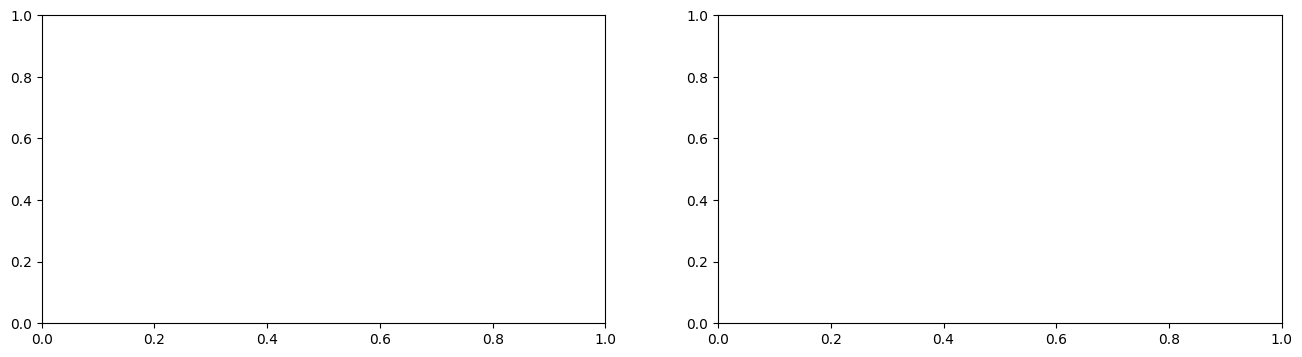

In [132]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

sns.barplot(
    data=df,
    y='smoothed_fp_success',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[0],
    palette='coolwarm'
)
axes[0].set_ylim(.4,.5)

sns.barplot(
    data=df,
    y='fp_epa',
    x='offense_formation',
    hue='personnel_num',
    ax=axes[1],
    palette='coolwarm'
)

In [ ]:
f_success = (
    df.groupby('offense_formation')
    .agg(
        plays=('success', 'count'),
        success_rate=('success', 'mean'),
        avg_epa=('epa', 'mean')
    )
    .reset_index()
)

global_success = df['success'].mean()
global_epa = df['epa'].mean()

f_success['smoothed_success'] = (
    (f_success['plays'] * f_success['success_rate'] + 10 * global_success)
    / (f_success['plays'] + 10)
)

f_success['smoothed_epa'] = (
    (f_success['plays'] * f_success['avg_epa'] + 10 * global_epa)
    / (f_success['plays'] + 10)
)

<Axes: xlabel='offense_formation', ylabel='avg_epa'>

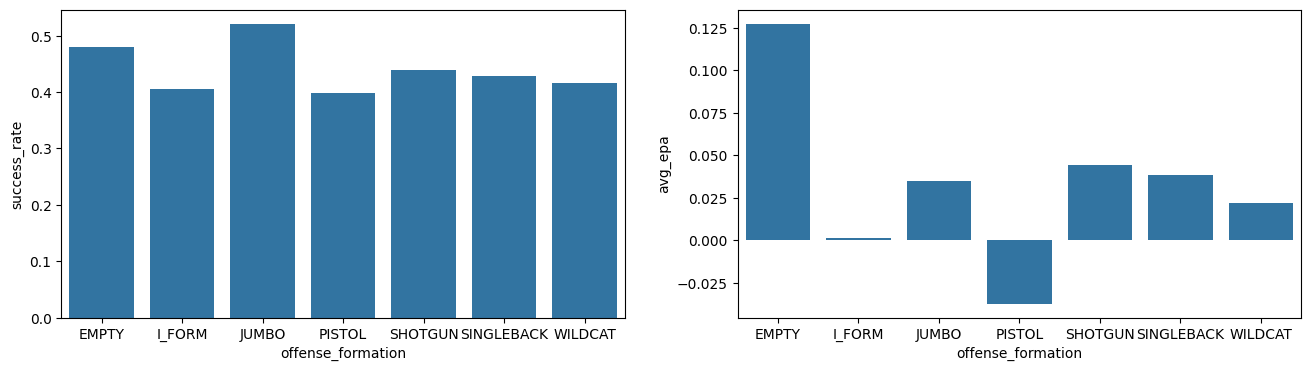

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
sns.barplot(data=f_success, x='offense_formation', y='success_rate', ax=axes[0])
sns.barplot(data=f_success, x='offense_formation', y='avg_epa', ax=axes[1])

In [ ]:
f_success

,offense_formation,plays,success_rate,avg_epa,smoothed_success,smoothed_epa
0,EMPTY,2638,0.479530,0.127505,0.479364,0.127182
1,I_FORM,3582,0.404802,0.001677,0.404888,0.001788
2,JUMBO,417,0.520384,0.034806,0.518400,0.034971
3,PISTOL,1247,0.397755,-0.037084,0.398056,-0.036456
4,SHOTGUN,17574,0.439399,0.044607,0.439397,0.044605
5,SINGLEBACK,7742,0.428571,0.038489,0.428581,0.038493
6,WILDCAT,154,0.415584,0.021756,0.416810,0.022982


In [ ]:
df['defense_personnel']

0              4 DL, 3 LB, 4 DB
1              4 DL, 3 LB, 4 DB
2              4 DL, 3 LB, 4 DB
3              4 DL, 3 LB, 4 DB
4              4 DL, 3 LB, 4 DB
                  ...          
33349          3 DL, 3 LB, 5 DB
33350          3 DL, 2 LB, 6 DB
33351          3 DL, 3 LB, 5 DB
33352    5 DL, 4 LB, 1 DB, 1 OL
33353          3 DL, 3 LB, 5 DB
Name: defense_personnel, Length: 33354, dtype: object

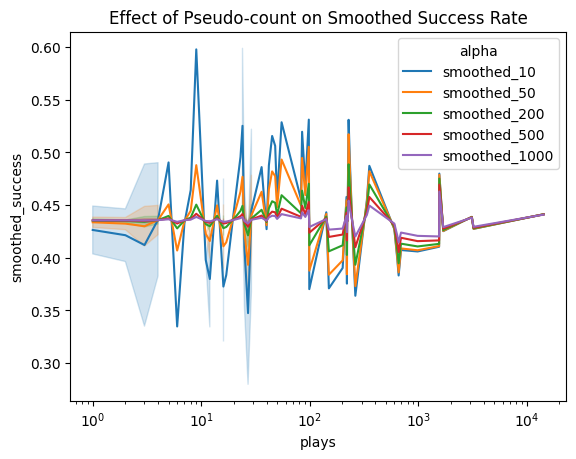

In [ ]:
for alpha in [10, 50, 200, 500, 1000]:
    fp_success[f'smoothed_{alpha}'] = (
        (fp_success['plays'] * fp_success['success_rate'] + alpha * global_success)
        / (fp_success['plays'] + alpha)
    )

sns.lineplot(
    data=fp_success.melt(
        id_vars=['offense_formation', 'plays'], 
        value_vars=[f'smoothed_{a}' for a in [10,50,200,500,1000]],
        var_name='alpha', 
        value_name='smoothed_success'
    ),
    x='plays', y='smoothed_success', hue='alpha'
)
plt.xscale('log')
plt.title('Effect of Pseudo-count on Smoothed Success Rate')
plt.show()

200 or 500 smoothing is sweet spot

0:	learn: 0.5439968	test: 0.5562806	best: 0.5562806 (0)	total: 71.7ms	remaining: 35.8s
20:	learn: 0.5729952	test: 0.5758427	best: 0.5872710 (10)	total: 235ms	remaining: 5.36s
40:	learn: 0.5808595	test: 0.5785366	best: 0.5872710 (10)	total: 403ms	remaining: 4.51s
60:	learn: 0.5917259	test: 0.5745283	best: 0.5872710 (10)	total: 567ms	remaining: 4.08s
80:	learn: 0.6047761	test: 0.5684307	best: 0.5872710 (10)	total: 722ms	remaining: 3.74s
100:	learn: 0.6138651	test: 0.5622807	best: 0.5872710 (10)	total: 882ms	remaining: 3.48s
120:	learn: 0.6231231	test: 0.5619390	best: 0.5872710 (10)	total: 1.04s	remaining: 3.25s
140:	learn: 0.6368958	test: 0.5599233	best: 0.5872710 (10)	total: 1.29s	remaining: 3.29s
160:	learn: 0.6378774	test: 0.5572093	best: 0.5872710 (10)	total: 1.49s	remaining: 3.15s
180:	learn: 0.6436966	test: 0.5441441	best: 0.5872710 (10)	total: 1.69s	remaining: 2.97s
200:	learn: 0.6486104	test: 0.5455349	best: 0.5872710 (10)	total: 1.86s	remaining: 2.76s
220:	learn: 0.6501219	test:

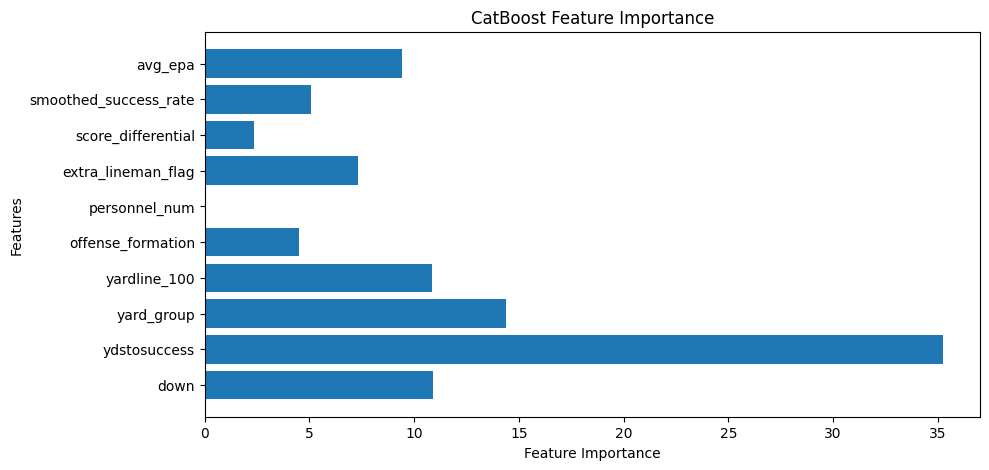

In [ ]:
# Suppose df has both numeric and categorical columns
features = ['down','ydstosuccess','yard_group','yardline_100','offense_formation','personnel_num','extra_lineman_flag','score_differential','smoothed_success_rate','avg_epa','success']
cat_features = ['yard_group','offense_formation','personnel_num']
target = 'success'

df = df[features]

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(
    cat_features=cat_features,
    iterations=500,
    learning_rate=0.2,
    depth=6,
    eval_metric='Precision',
    random_seed=42,
    verbose=20
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importances = model.get_feature_importance()
plt.figure(figsize=(10,5))
plt.barh(features[:-1], feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()

0:	learn: 0.5415324	test: 0.5327577	best: 0.5327577 (0)	total: 8.57ms	remaining: 8.56s
100:	learn: 0.5572671	test: 0.5592415	best: 0.5607091 (98)	total: 575ms	remaining: 5.12s
200:	learn: 0.5589459	test: 0.5526573	best: 0.5607091 (98)	total: 1.1s	remaining: 4.38s
300:	learn: 0.5608037	test: 0.5546565	best: 0.5607091 (98)	total: 1.62s	remaining: 3.77s
400:	learn: 0.5624635	test: 0.5555406	best: 0.5607091 (98)	total: 2.2s	remaining: 3.29s
500:	learn: 0.5625822	test: 0.5556734	best: 0.5607091 (98)	total: 2.78s	remaining: 2.77s
600:	learn: 0.5630863	test: 0.5555406	best: 0.5607091 (98)	total: 3.33s	remaining: 2.21s
700:	learn: 0.5641185	test: 0.5563376	best: 0.5607091 (98)	total: 3.89s	remaining: 1.66s
800:	learn: 0.5644413	test: 0.5565727	best: 0.5607091 (98)	total: 4.46s	remaining: 1.11s
900:	learn: 0.5652024	test: 0.5568232	best: 0.5607091 (98)	total: 4.99s	remaining: 548ms
999:	learn: 0.5657032	test: 0.5578945	best: 0.5607091 (98)	total: 5.54s	remaining: 0us

bestTest = 0.5607090578
be

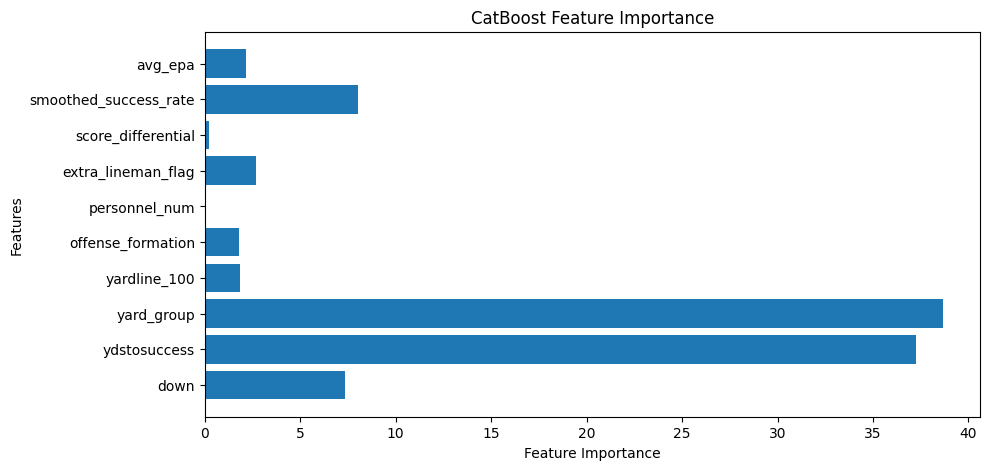

Accuracy: 0.572627791935242
              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63      3765
         1.0       0.51      0.47      0.49      2906

    accuracy                           0.57      6671
   macro avg       0.56      0.56      0.56      6671
weighted avg       0.57      0.57      0.57      6671



In [ ]:
model = CatBoostClassifier(
    cat_features=cat_features,
    auto_class_weights='Balanced',     # or auto_class_weights='Balanced'
    learning_rate=0.01,
    depth=3,
    iterations=1000,
    eval_metric='Accuracy',
    use_best_model=True,
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))

feature_importances = model.get_feature_importance()
plt.figure(figsize=(10,5))
plt.barh(features[:-1], feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
df.isna().mean()

down                     0.0
ydstosuccess             0.0
yard_group               0.0
yardline_100             0.0
offense_formation        0.0
personnel_num            0.0
extra_lineman_flag       0.0
score_differential       0.0
smoothed_success_rate    0.0
avg_epa                  0.0
success                  0.0
dtype: float64

In [ ]:
print(df.isna().sum().to_string())

nflverse_game_id                     0
play_id                              0
possession_team                      0
offense_formation                    0
offense_personnel                    0
defenders_in_box                     1
defense_personnel                    0
number_of_pass_rushers           13318
players_on_play                      1
offense_players                      1
defense_players                      1
n_offense                            0
n_defense                            0
ngs_air_yards                    14417
time_to_throw                    14397
was_pressure                     14398
route                            14659
old_game_id                          0
home_team                            0
away_team                            0
season_type                          0
week                                 0
posteam                              0
posteam_type                         0
defteam                              0
side_of_field            

In [ ]:
df = pd.read_csv('data/interim/pbp/featured_11_11.csv')

/tmp/ipykernel_29045/4019307888.py:1: DtypeWarning: Columns (8,9,95,96,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/interim/pbp/featured_11_11.csv')


In [ ]:
list(df.columns.to_list())

['nflverse_game_id',
 'play_id',
 'possession_team',
 'offense_formation',
 'defenders_in_box',
 'defense_personnel',
 'n_offense',
 'n_defense',
 'defense_man_zone_type',
 'defense_coverage_type',
 'home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'pass_length',
 'pass_location',
 'run_location',
 'run_gap',
 'score_differential',
 'score_differential_post',
 'no_score_prob',
 'fg_prob',
 'td_prob',
 'ep',
 'epa',
 'wp',
 'def_wp',
 'home_wp',
 'away_wp',
 'wpa',
 'home_wp_post',
 'away_wp_post',
 'third_down_converted',
 'third_down_failed',
 'fourth_down_converted',
 'fourth_down_failed',
 'penalty',
 'rush_attempt',
 'pass_attempt',
 'sack',


In [ ]:
df

,nflverse_game_id,play_id,possession_team,offense_formation,defenders_in_box,defense_personnel,n_offense,n_defense,defense_man_zone_type,defense_coverage_type,...,bigs,personnel_num,ydstosuccess,previous_success,fp_success,smoothed_fp_success,fp_epa,f_success,smoothed_f_success,f_epa
0,2016_01_BUF_BAL,58,BAL,I_FORM,8.0,"4 DL, 3 LB, 4 DB",11,11,NaN,NaN,...,1,12,5.0,0.0,0.420070,0.420936,0.018395,0.418838,0.419254,0.006341
1,2016_01_BUF_BAL,85,BAL,SHOTGUN,6.0,"4 DL, 3 LB, 4 DB",11,11,NaN,NaN,...,1,12,2.8,1.0,0.449474,0.448258,0.029282,0.438709,0.438703,0.016045
2,2016_01_BUF_BAL,109,BAL,SHOTGUN,7.0,"4 DL, 3 LB, 4 DB",11,11,NaN,NaN,...,1,12,5.0,1.0,0.449474,0.448258,0.029282,0.438709,0.438703,0.016045
3,2016_01_BUF_BAL,130,BAL,I_FORM,7.0,"4 DL, 3 LB, 4 DB",11,11,NaN,NaN,...,1,12,7.0,0.0,0.420070,0.420936,0.018395,0.418838,0.419254,0.006341
4,2016_01_BUF_BAL,154,BAL,I_FORM,8.0,"4 DL, 3 LB, 4 DB",11,11,NaN,NaN,...,2,21,1.0,1.0,0.409726,0.412816,-0.004188,0.418838,0.419254,0.006341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307572,2024_22_KC_PHI,4016,PHI,SHOTGUN,7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,NaN,NaN,...,0,1,5.0,0.0,0.435283,0.435404,0.016374,0.438709,0.438703,0.016045
307573,2024_22_KC_PHI,4038,PHI,SHOTGUN,7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,NaN,NaN,...,0,1,4.2,0.0,0.435283,0.435404,0.016374,0.438709,0.438703,0.016045
307574,2024_22_KC_PHI,4071,PHI,SHOTGUN,7.0,"2 CB, 2 DE, 1 DT, 1 FS, 2 ILB, 1 NT, 1 OLB, 1 SS",11,11,NaN,NaN,...,0,1,5.0,0.0,0.435283,0.435404,0.016374,0.438709,0.438703,0.016045
307575,2024_22_KC_PHI,4093,PHI,SHOTGUN,6.0,"2 CB, 2 DE, 1 DT, 2 FS, 2 ILB, 1 NT, 1 SS",11,11,MAN_COVERAGE,COVER_1,...,-1,-11,6.0,0.0,0.441535,0.441309,0.008912,0.438709,0.438703,0.016045


In [ ]:
test